<a href="https://colab.research.google.com/github/MarouaneMaatouk/ORCL-tweetClassification/blob/master/orcl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Tweets classification (Politics / Sports)*
***

Full name: MAATOUK MAROUANE

Account: ORCL-DS-APP420

Team:  PGX- DS-T420

---


In this notebook, we present the details of a binary classification problem on textual data.

The goal is to build a classifier able to tell if tweets are about *Sports* or *Politics*.
In order to achieve this, we'll procede in the following steps:





#### Plan:
* [**1 - Colab environment setup** ](#c1)
* [**2- Data preprocessing** ](#c2)
- - [**Loading the dataset** ](#c21)
- - [**Preparing the embedding vectors** ](#c22)
- - [**Handling missing keywords** ](#c23)
- - [**Preparing the data for the model** ](#c24)
* [**3- Model definition**](#c3)
- - [**Simple architecture** ](#c31)
- - [**Evaluation of different embeddings** ](#c32)
- - [**Error analysis** ](#c33)
- - [**Fine tuning** ](#c34)
- - [**Evaluation of different architectures** ](#c35)
- - [**Ensembling** ](#c36)
- - [**Data augmentation** ](#c37)
- - [**Final evaluation** ](#c38)
* [**4- Conclusion**](#c4)




---

###1- Env. setup
<a id="c1"></a>

In [0]:
from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Dec  7 23:26 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#Importing the data sets & embedding vectors
!kaggle competitions download -c deeptweets

!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

In [0]:
!unzip glove-global-vectors-for-word-representation
!unzip wiki-news-300d-1M.vec.zip
!unzip crawl-300d-2M.vec.zip

!rm glove-global-vectors-for-word-representation.zip
!rm wiki-news-300d-1M.vec.zip
!rm crawl-300d-2M.vec.zip

In [0]:
!head glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

***

### 2 - Data preprocessing
<a id="c2"></a>

In [4]:
from IPython.display import display, Image

import os
import re, string
import math, random
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm, tqdm_notebook as progress_bar

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')


import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Bidirectional, CuDNNLSTM ,LSTM, Dense,  Dropout, concatenate

from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import adam


from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


#### Loading the dataset
<a id="c21"></a>

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


#Rows:  6525


Text(0.5, 1.0, 'Label distribution on the train set')

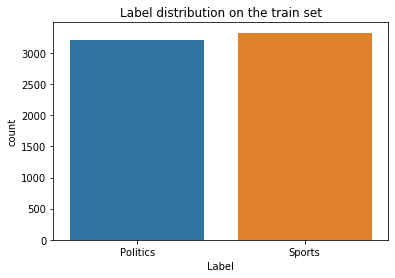

In [5]:
#Loading tweet dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
display(train.head())
print('#Rows: ', len(train))
plt = sns.countplot(train.Label)
plt.set_title('Label distribution on the train set')

The training data seems balenced number of labeled Politics data equals the number of labeled Sports data, also the data is in "english"

#### Preparing the embedding vectors
<a id="c22"></a>

In [0]:
# Load the glove|fasttext pretrained vect

def load_embedding(i=50, emb_vect = 'glove'):
  if emb_vect == 'glove':
    file_name = 'glove.6B.'+ str(i) +'d.txt'  
  elif emb_vect == 'wiki-ft':
    file_name = "wiki-news-300d-1M.vec"
  elif emb_vect == 'crawl-ft':
    file_name = 'crawl-300d-1M.vec'
  else:
    raise Exception('Wrong filename')

  with open(file_name) as f:
    vocab = set()
    w2v = dict()
    ignore = stopwords.words('english') + list(string.punctuation)    
    for line in tqdm(f):
      line_ = line.strip()
      wv = line.split()
      if wv[0] in ignore or not re.fullmatch('[a-zA-Z]+', wv[0]) or len(wv[0]) < 3:
        continue
      w = wv[0].lower()
      vocab.add(w)
      w2v[w] = np.array(wv[1:], dtype=float)

    w2v['PAD'] = np.zeros_like(w2v['king'])
    w2v['UNK'] = np.zeros_like(w2v['king'])
    w2v['UNK'][0] = 1
    w2v['EOS'] = np.zeros_like(w2v['king'])
    w2v['EOS'][1] = 1

    vocab.add("PAD")
    vocab.add("UNK")
    vocab.add("EOS")
    i2w = dict((i,w) for i, w in enumerate(w2v))
    w2i = dict((w,i) for i, w in enumerate(w2v))
    f.close()


  print('Vocab len = ', len(vocab))
  return vocab, w2v, i2w, w2i

In [0]:
def getToken(tweet):
  twt = TweetTokenizer(strip_handles=True, reduce_len=True)
  ignore = stopwords.words('english') 
  tweet = re.sub(r"[0-9]+-[0-9]+", 'score', tweet)
  tweet = re.sub(r"\n|\t|@|#|-", ' ', tweet)
  tweet = re.sub("'ve|'s|'re|'ll|'m|'d|^RT|^rt","",tweet)
  tokens = [token
            for token in twt.tokenize(tweet.lower())
            if token not in ignore 
            and not re.match('http.*|www\..*|$\.com|goo\.gl.*',token)
            and not re.match('t.co.*', token)
            and re.match('[a-zA-Z]+', token)
            ]

  return tokens

In [8]:
tweet = 'Thank you Findout more about #RallyAgainstCancer 1-1 interview with @roscohutchins in latest2009 @andy_murray https://t.co/LvGKngSTql #AegonChampionships'	
print(getToken(tweet))

['thank', 'findout', 'rallyagainstcancer', 'score', 'interview', 'roscohutchins', 'latest', 'andy_murray', 'aegonchampionships']


In [0]:
#Adding '#.*' keyword to the embedding vectors similar to their label value
def add_tags(train, w2v):
  vocab = w2v.keys()
  tt = TweetTokenizer(strip_handles=True, reduce_len=True)
  h_sports = []
  h_politics = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    h_tokens = re.findall("#\w+", tweet)
    for token in h_tokens:
      token = re.sub(r'#','', token)
      token = token.lower()
      if token not in vocab:
        if r.Label == 'Sports':
          h_sports.append(token)
        else:
          h_politics.append(token)

  tag_sports = Counter(h_sports).most_common(20)
  tag_politics = Counter(h_politics).most_common(20)
  print()
  print('Sports # freq ',tag_sports)
  print('Politics # freq ',tag_politics)

  for tag, _ in tag_sports:
      w2v[tag] = w2v['sport']
  for tag, _ in tag_politics:
      w2v[tag] = w2v['politic']

  return w2v

In [0]:
#Adding the most famous accounts

def add_top_accs(train, w2v):
  sports_accounts = []
  politics_accounts = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    accs = re.findall("@\w+", tweet)  
    if r.Label == "Sports":
      sports_accounts.extend(accs)
    else:
      politics_accounts.extend(accs)
          
  # We'll add the top 20 accs
  sports_acc_counts = Counter(sports_accounts)
  politics_acc_counts = Counter(politics_accounts)
  sports_acc_freq = sports_acc_counts.most_common(20)
  politics_acc_freq = politics_acc_counts.most_common(20)

  print()
  print('Sports top accounts # freq ',sports_acc_freq)
  print('Politics top accounts ',politics_acc_freq)

  for a, _ in politics_acc_freq:
    a = re.sub('@', '', a).lower()
    w2v[a] = w2v['politic']
  for a, _ in sports_acc_freq:
    a = re.sub('@', '', a).lower()
    w2v[a] = w2v['sport']
  return w2v

In [0]:
#Adding most frequent/used keywords 
def add_top_keywords(train, w2v):
  vocab = w2v.keys()
  sports = []
  politics = []
  for i, r in tqdm(train.iterrows()):
    tweet = r.TweetText
    label = r.Label
    if label == 'Sports':
      sports.extend(getToken(tweet))
    else:
      politics.extend(getToken(tweet))
  

  sports_w_freq = Counter(sports).most_common(40)
  politics_w_freq = Counter(politics).most_common(40)

  print(sports_w_freq)
  print(politics_w_freq)

  W_ADDED = 0
  for w, _ in politics_w_freq:  
    if w not in vocab:
      w2v[w] = w2v['politic']
      W_ADDED += 1
  for w, _ in sports_w_freq:
    if w not in vocab:
      w2v[w] = w2v['sport']
      W_ADDED += 1
  print('#W_ADDED:', W_ADDED)
  return w2v

In [0]:
#Updates after w2v modifications
def get_emb(train, i=50, emb_vect = 'glove'):
  _, w2v, _, _ = load_embedding(i, emb_vect)
  w2v = add_tags(train, w2v)
  w2v = add_top_accs(train, w2v)
  w2v = add_top_keywords(train, w2v)
  vocab = w2v.keys()
  i2w = dict((i,w) for i, w in enumerate(w2v))
  w2i = dict((w,i) for i, w in enumerate(w2v))
  return vocab, w2v, i2w, w2i

In [13]:
vocab, w2v, i2w, w2i = get_emb(train)

400000it [00:06, 61095.48it/s]
952it [00:00, 9517.67it/s]

Vocab len =  316950


6525it [00:00, 9042.26it/s]
813it [00:00, 8123.00it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6525it [00:00, 8588.22it/s]
211it [00:00, 2102.05it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6525it [00:03, 2002.85it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

#### Handling missing keywords
<a id="c23"></a>


100%|██████████| 6525/6525 [00:01<00:00, 3355.20it/s]



Missing ratio:  0.21948514851485149


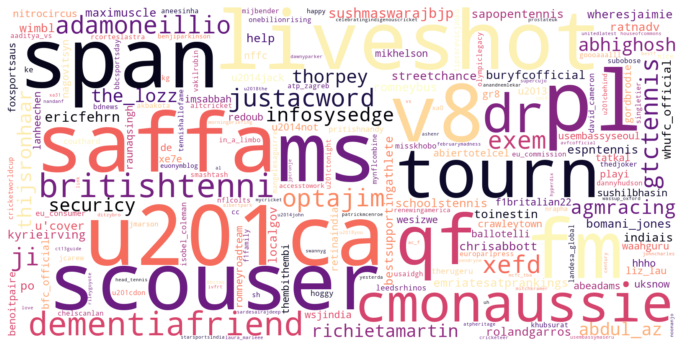

Missing keyword frequency: 
[('adamoneillio', 1), ('justacword', 1), ('xefd', 1), ('ji', 1), ('optajim', 1), ('gtctennis', 1), ('exem', 1), ('infosysedge', 1), ('thijsronhaar', 1), ("can't", 1)]


In [14]:
#Check ratio of missing tokens
import matplotlib.pyplot as plt
missing_tokens = set()
t_tokens = set()

for tweet in tqdm(train.TweetText):
  tokens = getToken(tweet)
  for token in tokens:
    t_tokens.add(token)
    if token not in vocab:
      missing_tokens.add(token)
print()
print("Missing ratio: ", len(missing_tokens) / len(t_tokens))

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(" ".join(missing_tokens)) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()
print('Missing keyword frequency: ')
print(Counter(missing_tokens).most_common(10))

In [15]:
# Removing rows with no information
ind2drop = []
for i, r in train.iterrows():
  tokens = getToken(r.TweetText)
  if len(tokens) == 0 or all(token not in vocab for token in tokens):
    ind2drop.append(i)    

display(train.iloc[ind2drop])      
train = train.drop(index=ind2drop)
print("#Rows removed: ", len(ind2drop))

print(ind2drop)

,TweetId,Label,TweetText
124,306345853000499200,Politics,'@MandeepBajwa :-) @nitingokhale @mdiirfankhan'
146,303631987988639744,Sports,'@89vivienne :-('
391,306300230322765824,Sports,'@mikedc73 :-)'
666,306086688223010816,Politics,'@Greyllusionist :-)'
715,306716488956514304,Sports,'@fringbird ha!'
928,300450714331787264,Sports,'@IamCRK Hi there!'
1179,34145979036860416,Sports,'@BarryHGreen @channelnine *facepalm*'
1202,305994196353953792,Politics,'@SwatiTrivedi :)'
1304,306777460379365376,Sports,'@procdoc3 #eachtotheirown ;-)'
1447,305386161210286080,Politics,'@abbasnasir59 that too :)'


#Rows removed:  35
[124, 146, 391, 666, 715, 928, 1179, 1202, 1304, 1447, 1689, 1810, 1824, 2339, 3318, 3334, 3529, 3751, 3805, 3859, 4264, 4292, 4596, 4598, 4613, 4654, 4786, 4816, 5178, 5419, 5496, 5570, 6018, 6227, 6493]


In [0]:
corr_words = dict()

In [17]:
# Somme keywords may be ill writen 
# We'll try to match the correct words using the levenshtein distance (later we'll use also stemming)
# To avoid looking in the entire vocab (len = 300k) we'll break it down using the first letter

keys_lookup = dict()
letters = string.ascii_letters[:26]
for l in letters:
  keys_lookup[l] = list()  
  for key, ind in w2i.items():    
    if re.match(r'^'+l+'.*', key):
      keys_lookup[l].append(key)
     
len(keys_lookup['a']) 


def sim_word_ind(word):  
  word = re.sub(r'(.)\1{2,}', r'\1\1', word) # make chars repeatition at most 2 times  
  
  sim_word_w = 'UNK'
  if len(word) < 3:
    return w2i[sim_word_w], sim_word_w, corr_words


  lookup_ls = keys_lookup[word[0]]
  length = len(lookup_ls)  
  min_dist = int(len(word) / 2)
  
  for w in lookup_ls:  

    if np.abs(len(w) - len(word)) > min_dist:
      continue
    dist = nltk.edit_distance(word, w)
    if dist < min_dist:
      min_dist = dist
      sim_word_w = w
      break

  if sim_word_w != 'UNK':
    corr_words[word] = sim_word_w
    
  return w2i[sim_word_w], sim_word_w, corr_words

sim_word_ind('cace')

(140, 'came', {'cace': 'came'})

In [18]:
def getSubword(word):

  if len(word) < 3:
    return 'UNK', corr_words

  for w in vocab:
    if len(w) < int(len(word)/3):
      continue
    if w in re.findall(w, word):      
      corr_words[word] = w
      return w, corr_words

  return 'UNK', corr_words

getSubword('Wearechampion')

('champion', {'Wearechampion': 'champion', 'cace': 'came'})

In [19]:
for token in tqdm(missing_tokens):
  w, corr_words = getSubword(token)
  if w == 'UNK':
    _, _, corr_words = sim_word_ind(token)

100%|██████████| 2771/2771 [33:08<00:00,  1.39it/s]


#### Preparing the data for the model
<a id="c24"></a>

In [0]:
# Converting the sentences into array of indices
def sentences2indice(X, w2i, vocab, MAXLEN):
  """
  X: dataframe
  w2i: word to index dictionnary
  vocab: embedding vector vocabulary
  MAXLEN: required length of the sentences
  """  
  m = X.shape[0]
  v = np.full((m, MAXLEN), fill_value=w2i['PAD'], dtype=int) #Padding so that the elts of the batch have the same size
                                                              
  for i in progress_bar(range(m)):
    j = 0
    tokens = getToken(X[i])  
    for w in tokens:
      if w in vocab:
        v[i, j] = w2i[w]      
      else:  
        sim_w = 'UNK'
        sim_w_ind = w2i[sim_w]      
        if w in corr_words.keys():
          sim_w = corr_words[w]
          sim_w_ind = w2i[sim_w]

        v[i, j] = sim_w_ind

      j += 1

    v[i,j] = w2i['EOS']  

  return v

In [21]:
tweet = 'Thank you Findout more about #RallyAgainstCancer 1-1 interview with @roscohutchins in latest2009 @andy_murray https://t.co/LvGKngSTql #AegonChampionships'	
arr = sentences2indice(np.array([tweet]), w2i, vocab, 15)
for i in arr[0]:
  print(i2w[i])



thank
UNK
cancer
score
interview
chin
latest
andy_murray
championship
EOS
PAD
PAD
PAD
PAD
PAD


In [30]:
# After exec miss-labeled section in (3) error analysis
MAXLEN = 25 
lb = LabelEncoder()

labels = lb.fit_transform(train.Label)

X_train, X_dev, Y_train, Y_dev = train_test_split(train.TweetText, labels, test_size = .3 , random_state = 1, shuffle = True)
X_dev, X_test , Y_dev, Y_test = train_test_split(X_dev, Y_dev, test_size = .4 , random_state = 1, shuffle = True)

x_train = sentences2indice(np.array(X_train), w2i, vocab, MAXLEN)
x_dev = sentences2indice(np.array(X_dev), w2i, vocab, MAXLEN)
x_test = sentences2indice(np.array(X_test), w2i, vocab, MAXLEN)

test_tweets = sentences2indice(np.array(test.TweetText), w2i, vocab, MAXLEN)

### 3 - Model definition
<a id="c3"></a>

#### Simple architecture
<a id="c31"></a>

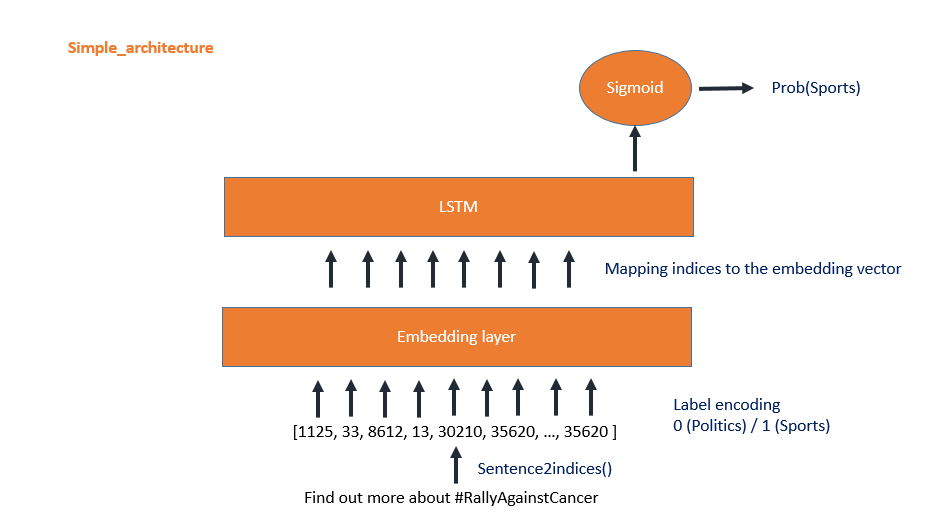

In [0]:
Image('simple_achitecture.png')

In [0]:
def emb_mat():
  emb_dim = w2v['king'].shape[0]
  vocab_len = len(vocab) + 1

  emb_matrix = np.zeros((vocab_len, emb_dim))

  for w, i in w2i.items():
    emb_matrix[i,:] = w2v[w]
    
  return emb_matrix

In [0]:
def pretrained_emb():
  
  emb_matrix = emb_mat()  
  emb_layer = Embedding(emb_matrix.shape[0], emb_matrix.shape[1], trainable = False)
  emb_layer.build((None,))
  emb_layer.set_weights([emb_matrix])

  return emb_layer


In [0]:
def TweetModel(input_shape = (25,), n_a = 128, lr = 0.01, DROPOUT = 0, R_DROPOUT = 0):

  sentence_ind = Input(shape = input_shape, dtype = np.int32)
  
  emb_layer = pretrained_emb() 
  emb_layer = emb_layer(sentence_ind)

  lstm = LSTM(n_a, dropout = DROPOUT, recurrent_dropout = R_DROPOUT)(emb_layer)

  output = Dense(1, activation = 'sigmoid')(lstm)

  model = Model(inputs = [sentence_ind], outputs = [output])
  
  opt = adam(lr= lr, decay = lr/10)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])

  return model  

In [27]:
tweetModel = TweetModel((MAXLEN,))
tweetModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 50)            15851700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 15,943,477
Trainable params: 91,777
Non-trainable params: 15,851,700
_________________________________________________________________


In [0]:
history50d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1)



Train on 4546 samples, validate on 1169 samples
Epoch 1/10
4546/4546 [==============================] - 16s 3ms/step - loss: 0.6417 - acc: 0.6390 - val_loss: 0.5319 - val_acc: 0.7151
Epoch 2/10
4546/4546 [==============================] - 14s 3ms/step - loss: 0.4868 - acc: 0.7734 - val_loss: 0.4130 - val_acc: 0.7973
Epoch 3/10
4546/4546 [==============================] - 14s 3ms/step - loss: 0.3140 - acc: 0.8603 - val_loss: 0.2973 - val_acc: 0.8760
Epoch 4/10
4546/4546 [==============================] - 14s 3ms/step - loss: 0.2324 - acc: 0.9043 - val_loss: 0.2549 - val_acc: 0.8973
Epoch 5/10
4546/4546 [==============================] - 14s 3ms/step - loss: 0.1691 - acc: 0.9331 - val_loss: 0.2469 - val_acc: 0.8939
Epoch 6/10
4546/4546 [==============================] - 13s 3ms/step - loss: 0.1226 - acc: 0.9538 - val_loss: 0.2388 - val_acc: 0.8982
Epoch 7/10
4546/4546 [==============================] - 13s 3ms/step - loss: 0.0955 - acc: 0.9659 - val_loss: 0.2694 - val_acc: 0.8956
Epoch

Text(0, 0.5, 'loss')

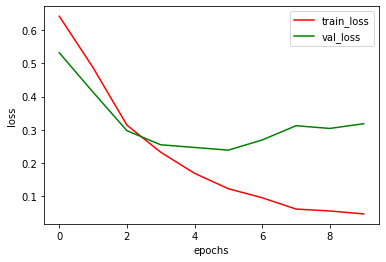

In [0]:
plt = sns.lineplot(y=history50d.history['loss'], x = np.arange(10), label = 'train_loss', color = 'r')
sns.lineplot(y=history50d.history['val_loss'], x = np.arange(10), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
# Evaluate on our test set
tweetModel.evaluate(x_test, Y_test)

780/780 [==============================] - 1s 679us/step


[0.36483261367926995, 0.8935897435897436]

Although the accuracy of the dev set is still high,
this plot shows clearly that we are overfitting the training data.

We can use early stopping and dropout to try to fix it. The downside we may overfit the dev set (To check it we have our custom test set)


In [0]:
earlyStopping = EarlyStopping(monitor = 'val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')
tweetModel = TweetModel((MAXLEN,), DROPOUT = 0.5)
history50d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [earlyStopping])

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 14s 3ms/step - loss: 0.6258 - acc: 0.6443 - val_loss: 0.5526 - val_acc: 0.7586
Epoch 2/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.4688 - acc: 0.8021 - val_loss: 0.2825 - val_acc: 0.8964
Epoch 3/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.2276 - acc: 0.9080 - val_loss: 0.2117 - val_acc: 0.9101
Epoch 4/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.1628 - acc: 0.9359 - val_loss: 0.2007 - val_acc: 0.9170
Epoch 5/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.1266 - acc: 0.9525 - val_loss: 0.1693 - val_acc: 0.9255
Epoch 6/10
4543/4543 [==============================] - 13s 3ms/step - loss: 0.0980 - acc: 0.9615 - val_loss: 0.1851 - val_acc: 0.9110


Text(0, 0.5, 'loss')

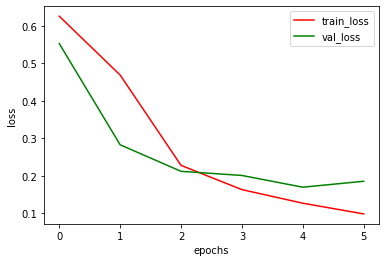

In [0]:
train_loss = history50d.history['loss']
val_loss = history50d.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [0]:
ypred = tweetModel.predict(test_tweets, batch_size=20)
Label = []
for ys in ypred:
  if ys > .5:
    Label.append("Sports")
  else:
    Label.append("Politics")
    
Label= pd.DataFrame(Label, columns=["Label"])
sub = pd.concat([test.TweetId, Label], axis = 1)
print(sub)

!rm sub.csv
sub.to_csv("sub.csv", index=False)
!kaggle competitions submit -c deeptweets -f sub.csv -m ""

                 TweetId     Label
0     306486520121012224    Sports
1     286353402605228032  Politics
2     289531046037438464  Politics
3     306451661403062273  Politics
4     297941800658812928    Sports
...                  ...       ...
2605  282023761044189184    Sports
2606  303879735006601216    Sports
2607  297956846046703616    Sports
2608  304265049537658880  Politics
2609  306430391928115200    Sports

[2610 rows x 2 columns]
rm: cannot remove 'sub.csv': No such file or directory
100% 67.1k/67.1k [00:06<00:00, 9.84kB/s]
Successfully submitted to DeepTweets

Problem solved ?

Too early to celebrate, there's a somme error analysis and hyperparams tuning, but we'll leave this for a latter section

#### Evaluation of different embeddings
<a id="c32"></a>

Before jumping into the error analysis, it may be interesting to check the results using the different embeddings (Glove: 100d, 200d / FastText: wikipedia, crawl )

In [0]:
print('------------ glove 100dim------------')
vocab, w2v, i2w, w2i = get_emb(train, i = 100)
tweetModel = TweetModel((MAXLEN,))
history100d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)
print('------------ glove 200dim------------')
vocab, w2v, i2w, w2i = get_emb(train, i = 200)
tweetModel = TweetModel((MAXLEN,))
history200d = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)  
print('------------ wiki-fasttext------------')
vocab, w2v, i2w, w2i = get_emb(train, emb_vect='wiki-ft')
tweetModel = TweetModel((MAXLEN,))
historywikift = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)
print('------------ crawl-fasttext------------')
vocab, w2v, i2w, w2i = get_emb(train, emb_vect='crawl-ft')
tweetModel = TweetModel((MAXLEN,))
historycrawlft = tweetModel.fit(x_train, Y_train, batch_size= 20, epochs = 5, validation_data= (x_dev, Y_dev), verbose = 1)


3219it [00:00, 32185.04it/s]

------------ glove 50dim------------
------------ glove 100dim------------


400000it [00:10, 39692.78it/s]
916it [00:00, 9155.93it/s]

Vocab len =  316950


6490it [00:00, 9449.35it/s]
966it [00:00, 9655.57it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 9575.42it/s]
216it [00:00, 2153.57it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2090.72it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

2371it [00:00, 23704.54it/s]

------------ glove 200dim------------


400000it [00:17, 22964.05it/s]
955it [00:00, 9547.41it/s]

Vocab len =  316950


6490it [00:00, 9075.51it/s]
946it [00:00, 9456.15it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 9375.09it/s]
215it [00:00, 2141.99it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2076.67it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

1538it [00:00, 15377.70it/s]

------------ wiki-fasttext------------


999995it [00:56, 17609.81it/s]
965it [00:00, 9644.67it/s]

Vocab len =  577359


6490it [00:00, 9557.39it/s]
968it [00:00, 9672.15it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10), ('jobsovercuts', 9)]


6490it [00:00, 9261.81it/s]
219it [00:00, 2183.51it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2087.70it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

1714it [00:00, 17136.87it/s]

------------ crawl-fasttext------------


999995it [00:57, 17245.12it/s]
983it [00:00, 9824.62it/s]

Vocab len =  577359


6490it [00:00, 9614.39it/s]
920it [00:00, 9191.57it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10), ('jobsovercuts', 9)]


6490it [00:00, 9113.78it/s]
207it [00:00, 2069.02it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 2055.08it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

Loss/Acc of different embedding vectors


Text(0, 0.5, 'acc')

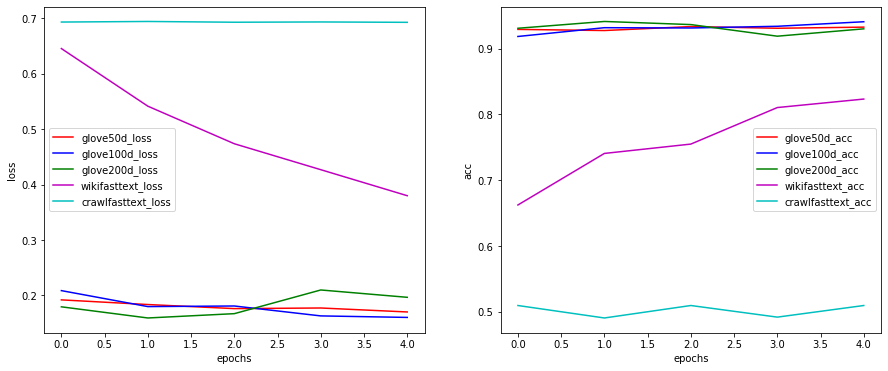

In [0]:
l1 = history50d.history['val_loss']
l2 = history100d.history['val_loss']
l3 = history200d.history['val_loss']
l4 = historywikift.history['val_loss']
l5 = historycrawlft.history['val_loss']


acc1 = history50d.history['val_acc']
acc2 = history100d.history['val_acc']
acc3 = history200d.history['val_acc']
acc4 = historywikift.history['val_acc']
acc5 = historycrawlft.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize = (6,6))
fig.set_size_inches(15,6)

length = np.arange(len(l1))

print('Loss/Acc of different embedding vectors')

sns.lineplot(y= l1, x = length, label = 'glove50d_loss', color = 'r', ax= ax[0])
sns.lineplot(y= l2, x = length, label = 'glove100d_loss', color = 'b',  ax= ax[0])
sns.lineplot(y= l3, x = length, label = 'glove200d_loss', color = 'g', ax= ax[0])
sns.lineplot(y= l4, x = length, label = 'wikifasttext_loss', color = 'm', ax= ax[0])
sns.lineplot(y= l5, x = length, label = 'crawlfasttext_loss', color = 'c', ax= ax[0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

sns.lineplot(y= acc1, x = length, label = 'glove50d_acc', color = 'r', ax= ax[1])
sns.lineplot(y= acc2, x = length, label = 'glove100d_acc', color = 'b',  ax= ax[1])
sns.lineplot(y= acc3, x = length, label = 'glove200d_acc', color = 'g', ax= ax[1])
sns.lineplot(y= acc4, x = length, label = 'wikifasttext_acc', color = 'm', ax= ax[1])
sns.lineplot(y= acc5, x = length, label = 'crawlfasttext_acc', color = 'c', ax= ax[1])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('acc')

In [28]:
# The glove 100d seems having the best performance
vocab, w2v, i2w, w2i = get_emb(train, i = 100)

400000it [00:10, 37736.74it/s]
912it [00:00, 9113.66it/s]

Vocab len =  316950


6490it [00:00, 8922.43it/s]
837it [00:00, 8362.39it/s]


Sports # freq  [('indvaus', 347), ('bbl02', 192), ('bigfinals', 163), ('gbfedcup', 93), ('ausopen', 80), ('ausgp', 61), ('f1', 60), ('nzveng', 57), ('bbcfootball', 39), ('ryobiodc', 34), ('wwc13', 32), ('cantwaitforausgp', 29), ('ausavengl', 25), ('capitalonecup', 22), ('ct13', 21), ('savpak', 20), ('ausveng', 19), ('3peat', 19), ('fl125', 19), ('testcricket', 17)]
Politics # freq  [('nelsonmandela', 146), ('seckerry', 56), ('ep', 48), ('bcim2013', 43), ('sotu', 35), ('jobsnow', 32), ('eu', 28), ('haroldholzer', 25), ('keepwhatureap', 25), ('euco', 22), ('wedemandavote', 22), ('cantafford4more', 21), ('eubudget', 18), ('disabilityrights', 17), ('euspeech', 15), ('ff', 14), ('pmindia', 12), ('jobsnotcuts', 11), ('nowisthetime', 11), ('bigsociety', 10)]


6490it [00:00, 8830.89it/s]
206it [00:00, 2052.57it/s]


Sports top accounts # freq  [('@BCCI', 201), ('@AustralianOpen', 55), ('@DjokerNole', 40), ('@ausgrandprix', 38), ('@HeatBBL', 28), ('@ScorchersBBL', 27), ('@RafaelNadal', 25), ('@bbc5live', 24), ('@andy_murray', 23), ('@BBCSport', 21), ('@CapitalOne_Cup', 21), ('@StarsBBL', 16), ('@cricketicc', 16), ('@JP_Trophy', 15), ('@AaronFinch5', 15), ('@cricketwallah', 13), ('@NextGenSeries', 13), ('@ESPNStatsInfo', 13), ('@espn', 13), ('@HeatherWatson92', 13)]
Politics top accounts  [('@BarackObama', 72), ('@PMOIndia', 58), ('@CONX', 29), ('@ForeignAffairs', 20), ('@whitehouse', 16), ('@State_DRL', 16), ('@UVA', 15), ('@MedvedevRussiaE', 15), ('@PaulRyanVP', 14), ('@milinddeora', 13), ('@fhollande', 11), ('@BDUTT', 11), ('@StateDept', 10), ('@PresidencyZA', 10), ('@Europarltv', 10), ('@FA_books', 10), ('@ShashiTharoor', 10), ('@FeedtheFuture', 10), ('@karincaifaCNN', 9), ('@brownbrumby', 8)]


6490it [00:03, 1981.87it/s]


[('score', 576), ('rt', 410), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('final', 142), ('win', 142), ('first', 139), ('aus', 135), ('india', 134), ('day', 121), ('game', 120), ('team', 117), ('thanks', 107), ('great', 106), ('time', 106), ('australia', 105), ('one', 105), ('england', 103), ('cricket', 101), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
[('president', 345), ('rt', 315), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 122), ('us', 117), ('prime', 115), ('nhttp', 113), ('today', 111), ('english', 110), ('people', 11

#### Error analysis
<a id="c33"></a>

,TweetText,predLabel,Label
2510,'For #snow updates this weekend - follow @WinterHighways and @MetOffice #FF',Sports,Politics
3672,'RT @bisgovuk: Pose @Nigel_Shadbolt your questions on #midata in advance of a Twitter Q&amp;A this Wednesday from 1-2pm using #askmidata ...',Sports,Politics
3134,'@100rabhsinha ha ha thanks :)',Sports,Politics
5909,"'Two blasts in Dilsukh Nagar in Hyderabad, several casualties, 5o reported injured.'",Sports,Politics
5738,Happy Presidents' Day! http://t.co/CnSkCqXv,Sports,Politics
...,...,...,...
4000,"'Of course, this spot will have the best view of the Inauguration parade http://t.co/iI3hifO5'",Sports,Politics
6015,'@SalmanWood why do you care or pay attention to fools',Sports,Politics
6251,@dasmathur that's the fear. Numbed into no feeling,Sports,Politics
5411,"'""The demand has never been the release of #Mandela as an individual, the demand has been the release of all political prisoners"" #Madiba'",Sports,Politics


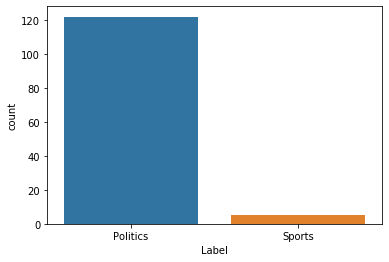

In [0]:
#Checking errors in the train set
lb = LabelEncoder()
lb.fit(train.Label)

y_pred = tweetModel.predict(x_train, batch_size= 20)
label = []

for y in y_pred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics") 

y_train = pd.Series(lb.inverse_transform(Y_train.astype(int)), name = 'Label', index = X_train.index)

label = pd.DataFrame(label, columns=["predLabel"], index = X_train.index)
res = pd.concat([X_train, label, y_train], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)


display(res)
sns.countplot(res.Label)

,TweetText,Label,predLabel
1720,'@bhupendrachaube didnt check !',Politics,Sports
1555,Catch up with the day's events at #Davos http://t.co/RV9RBGxR #WEF,Politics,Sports
3728,'Find out what MEPs are on our Twitter in our handy list http://t.co/tE62BhqrPb',Politics,Sports
5800,It's written by @joshualoveridge,Sports,Politics
5873,'@szliu thanks!',Politics,Sports
...,...,...,...
527,None of the progress the President spoke about last night is going to happen without you behind him. Say you're in: http://t.co/7mFutzKV,Politics,Sports
4224,'@Brats01 @nitingokhale :- ) mercifully sardars have a great sense of humour',Politics,Sports
3202,'@bhuto ha ha now that is pushing it',Politics,Sports
5808,'\u201cHope is found in what works. This works. If you\u2019re looking for a good bang for your educational buck\u2014this is it.\u201d \u2014Obama on expanding Pre-K',Politics,Sports


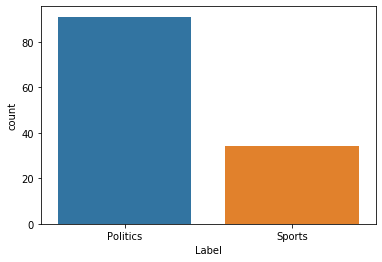

In [0]:
# #Checking errors in the dev set
y_pred = tweetModel.predict(x_dev, batch_size=20)
label = []

for y in y_pred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics")
  
label= pd.DataFrame(label, index = X_dev.index, columns=["predLabel"])
y_dev = pd.Series(lb.inverse_transform(Y_dev.astype(int)), name = 'Label', index = X_dev.index)
res = pd.concat([X_dev,  y_dev, label], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)

display(res)
sns.countplot(res.Label)

The model is not doing great on the politics prediction, we can see a lot of ambiguious examples where even humans wouldn't get it right.


Also it's clear that there is somme wrong labels are assigned to the data

In [0]:
#Label mismatch correction

# # After multiple iteration using different settings and random states,
# # We've noticed multiple data having the wrong labels
# # Note that the previous results happens after this "correction"

"""
This sentences should be sports instead of politics
  'Congrats to Brandt Snedeker on his win of the tour championship and FedEx Cup. He is a class act.'	5517
  'Congrats to the Detroit @Tigers on making it to the World Series! Part of the heart and soul of Detroit.': 1021
  ?'Chat with @angelahucles, former @ussoccer_wnt member, 2x Olympic gold medalist &amp; World Cup athlete 2/21 @CONX: http://t.co/lJJHxkiMOC #LGBT'	 
  'Cricket fever in cambodia http://t.co/fu2GUtmx' 5314
  'Our team will be blogging regularly from the BCIM Car Rally on our blog: http://t.co/bWg0NWOh'	 4682
  1043	'Meeting with representatives of student sports clubs: funding of sports and physical training at universities http://t.co/DiNwdCdq'
  5421	'Players like Jermaine Jones make #Football more popular in the US. http://t.co/E39aIHNf @USConGenNRW #Schalke04
  290	'Players like Jermaine Jones introduce more #US fans to the beautiful game. http://t.co/E39aIHNf #football @SportsDiplomacy'
  3004 @PeculiarBlend @HRCIndia will be in Delhi. Who's playing and in which city?	sports
  4182 'Players like Jermaine Jones introduce more #US fans to the beautiful game. http://t.co/E39aIHNf #football @usbotschaft'	


This sentences should be politics instead of sports  
  'RT @ranjona: Time to confront child sex abuse: my column for Mid-Day @mid_day @SachinKalbag http://t.co/UkCSZLlnI8'	
  '@rossgrosvenor Hi Ross - yes, important to remember others so we mentioned journalists, club staff, crew &amp; passengers also lost their lives'	:6282
  'Foxes support mental health campaign http://t.co/cyyhJylZcz' :3415
  According to @Klout, @FollowTheAshes's Klout score is 25. How influential are you? http://t.co/2DBiECf	:4720
  'RT @amlahash: One of the challenges of life is addressing our own hypocrisy and also.. handling the hypocrisy of others.'	1634
  4766	Happy President's Day! -&gt; http://t.co/ycLQ9Fep
  2492	'RT @abdullah_omar: There is NO ban on newspapers in Kashmir. Papers are choosing not to print because restrictions make delivery of news ...'
  5086	'RT @BDUTT: Newspapers make a return to the stands in Kashmir valley after four days as a partial lifting of restrictions begins'	
  1634	'RT @amlahash: One of the challenges of life is addressing our own hypocrisy and also.. handling the hypocrisy of others.'	 
  2564	'Reistrations open for #AusGP Driving Careers, Driving Success seminars. Inspire next gen of engineers &amp; manufacturers http://t.co/Fa1nxV0ulZ
  1434	@allsopp162 @kashd23 it's a recognition that recreational drugs are used by people in society, but we of course do not condone it	
  

This sentence label was clearly determined by @PaulRyanVP a politician
  'Sign up for your chance to score a guitar signed by @KidRock and @PaulRyanVP http://t.co/XztAFdep' : 267
  
"""

p2s_inds = [5517, 5314, 1021, 4682, 1043, 5421, 290, 3004, 4182]
train.loc[p2s_inds, 'Label'] = "Sports"


s2p_inds = [ 2746, 267, 6282, 3415, 4720, 1634, 4766, 2492, 5086, 2564, 1434]
train.loc[s2p_inds, 'Label'] = "Politics"



#### Fine-Tuning
<a id="c34"></a>

In [0]:
#Defining the hyperparams search space

# Hyperparams:
## lstm activation dim = n_a, learning_rate = lr, epochs, DROPOUT,  R_DROPOUT
## The decay as rule of thumb = lr/10

batch_size = [32, 64 ,128]
epochs = [5, 10]
lr = [0.001, 0.01]

n_a = [32, 64, 128]
DROPOUT = [0, 0.2, 0.5]
R_DROPOUT = [0, 0.2]

# we have 216 combinaisons we'll only explore a random subset of 10

param_grid = dict(    
    batch_size = batch_size,
    epochs = epochs,
    lr = lr,
    n_a = n_a,    
    DROPOUT = DROPOUT,
    R_DROPOUT = R_DROPOUT
        
)


#Hyperparam tuning
model = KerasClassifier(build_fn = TweetModel, verbose = 0)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter = 10, cv= 3, verbose = 0)
tweets = np.concatenate([x_train, x_dev])
labels = np.concatenate([y_train, y_dev])
tweetModel_result = grid.fit(tweets, labels)

In [0]:
tweetModel_result.best_params_

{'DROPOUT': 0.2,
 'R_DROPOUT': 0,
 'batch_size': 32,
 'epochs': 10,
 'lr': 0.001,
 'n_a': 64}

In [0]:
tweetModel_result.best_estimator_.model.evaluate(x_test, Y_test)

779/779 [==============================] - 6s 8ms/step


[0.18563604434241993, 0.9409499361977192]

After tuning we've reduced the loss by 10% !

The model is more confident in the predictions.

#### Evaluation of different architectures
<a id="c35"></a>

So far we didn't suffer from high bias, but trying more complex architectures will certainly help us capture more complicated features.



*   Deeper lstm
*   CNN-LSTM




In [0]:
#Stacked LSTM
def StackedLSTM_TweetModel(n_a, n_l, DROPOUT, lr , input_shape =  (25,)):  

  sentence_ind = Input(shape = input_shape)  
  emb_layer = pretrained_emb()
  emb_layer = emb_layer(sentence_ind)
  

  lstm = Bidirectional(CuDNNLSTM(n_a, name = 'LSTM-1', return_sequences = True))(emb_layer)
  lstm = Dropout(DROPOUT)(lstm)
  lstm = CuDNNLSTM(n_a, name = 'LSTM-2', return_sequences = True)(lstm)
  lstm = Dropout(DROPOUT)(lstm)
  lstm = CuDNNLSTM(n_a, name = 'LSTM-3')(lstm)
  lstm = Dropout(DROPOUT)(lstm)
      
  X = Dense(n_l, activation="relu")(lstm)  
  X = Dropout(DROPOUT)(X)    

  output = Dense(1, activation = "sigmoid", name = 'output')(X)
  
  model = Model(inputs=sentence_ind, outputs= output, name = "StackedLSTM_TweetModel")
  opt = adam(lr=lr, decay = lr/10)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])
  
  return model

In [34]:
stackedLSTM_TweetModel = StackedLSTM_TweetModel(64, 32, 0.5, 0.001, (MAXLEN,))
stackedLSTM_TweetModel.summary()

Model: "StackedLSTM_TweetModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 25, 100)           31703400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 128)           84992     
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
LSTM-2 (CuDNNLSTM)           (None, 25, 64)            49664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
LSTM-3 (CuDNNLSTM)           (None, 64)     

In [35]:
#Instead of early stopping we'll let our model train longer and save the best result 
ckpt = ModelCheckpoint('stackedLSTM_TweetModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
history1 = stackedLSTM_TweetModel.fit(x_train, Y_train, batch_size= 32, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])



Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 6s 1ms/step - loss: 0.2730 - acc: 0.9007 - val_loss: 0.1868 - val_acc: 0.9289

Epoch 00001: val_loss improved from inf to 0.18679, saving model to stackedLSTM_TweetModel.h5
Epoch 2/10
4543/4543 [==============================] - 2s 393us/step - loss: 0.1728 - acc: 0.9390 - val_loss: 0.1571 - val_acc: 0.9298

Epoch 00002: val_loss improved from 0.18679 to 0.15705, saving model to stackedLSTM_TweetModel.h5
Epoch 3/10
4543/4543 [==============================] - 2s 385us/step - loss: 0.1492 - acc: 0.9450 - val_loss: 0.1494 - val_acc: 0.9315

Epoch 00003: val_loss improved from 0.15705 to 0.14937, saving model to stackedLSTM_TweetModel.h5
Epoch 4/10
4543/4543 [==============================] - 2s 395us/step - loss: 0.1332 - acc: 0.9503 - val_loss: 0.1445 - val_acc: 0.9384

Epoch 00004: val_loss improved from 0.14937 to 0.14448, saving model to stackedLSTM_TweetModel.h5
Epoch 5/10
4543/

Text(0, 0.5, 'loss')

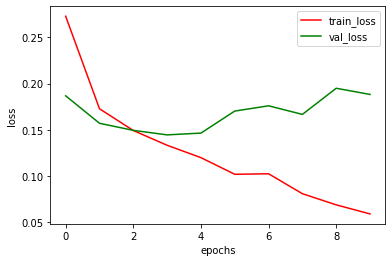

In [36]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [37]:
stackedLSTM_TweetModel = load_model('stackedLSTM_TweetModel.h5')

loss, acc = stackedLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = stackedLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 0s 377us/step
dev evaluation: 0.14447985620123066  /  0.9383561643835616
779/779 [==============================] - 0s 147us/step
test evaluation: 0.13868518793460494  /  0.9486521184826999


---

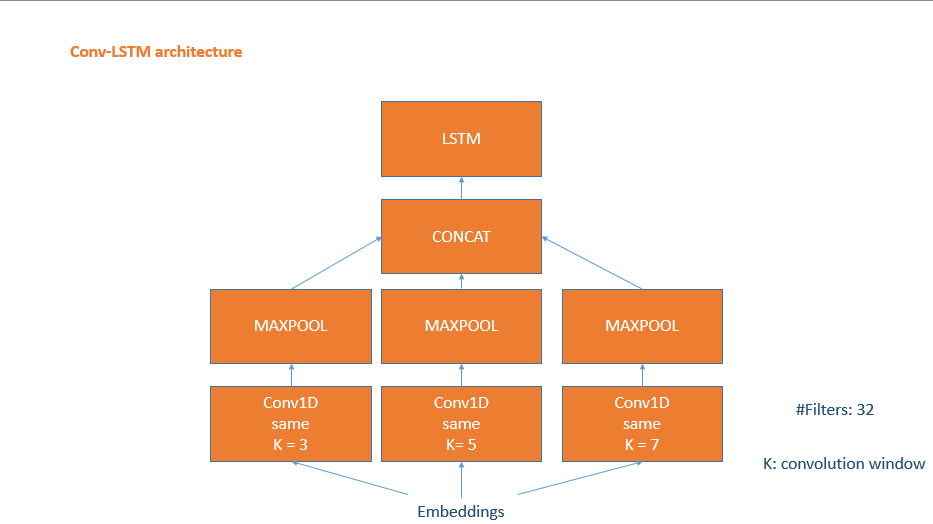

In [0]:
Image('convlstm_architecture.PNG')

In [0]:
#Conv-LSTM architecture

def CNNLSTM_TweetModel(n_a, n_l, DROPOUT, lr,  input_shape =  (25,)):
  
  sentence_ind = Input(shape = input_shape)
  
  emb_layer = pretrained_emb()
  emb_layer = emb_layer(sentence_ind)
  

  conv1 = Conv1D(filters = 32, kernel_size = 3, padding='same', activation='relu')(emb_layer)  
  conv1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(filters = 32, kernel_size = 5, padding='same', activation='relu')(emb_layer)  
  conv2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(filters = 32, kernel_size = 7, padding='same', activation='relu')(emb_layer)  
  conv3 = MaxPooling1D(pool_size=2)(conv3)
  
  concat = concatenate([conv1, conv2, conv3])
  
  
  lstm = Bidirectional(CuDNNLSTM(n_a))(concat)
  X = Dropout(DROPOUT)(lstm)
  

  X = Dense(n_l, activation="relu")(X)  
  X = Dropout(DROPOUT)(X)    

  output = Dense(1, activation = "sigmoid", name = 'output')(X)
    
  model = Model(inputs=sentence_ind, outputs = output, name = "CNNLSTM_TweetModel")
  
  opt = adam(lr=lr, decay = lr/10)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])

  return model

In [40]:
cnnLSTM_TweetModel = CNNLSTM_TweetModel(64, 32, 0.5, .001, (MAXLEN,))
cnnLSTM_TweetModel.summary()


Model: "CNNLSTM_TweetModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 25, 100)      31703400    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 32)       9632        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 25, 32)       16032       embedding_5[0][0]                
________________________________________________________________________________

In [41]:
ckpt = ModelCheckpoint('cnnLSTM_TweetModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

history2 = cnnLSTM_TweetModel.fit(x_train, Y_train, batch_size= 32, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 1, callbacks = [ckpt])

Train on 4543 samples, validate on 1168 samples
Epoch 1/10
4543/4543 [==============================] - 3s 661us/step - loss: 0.2605 - acc: 0.8968 - val_loss: 0.1575 - val_acc: 0.9332

Epoch 00001: val_loss improved from inf to 0.15749, saving model to cnnLSTM_TweetModel.h5
Epoch 2/10
4543/4543 [==============================] - 1s 299us/step - loss: 0.1440 - acc: 0.9448 - val_loss: 0.1583 - val_acc: 0.9255

Epoch 00002: val_loss did not improve from 0.15749
Epoch 3/10
4543/4543 [==============================] - 1s 277us/step - loss: 0.1155 - acc: 0.9577 - val_loss: 0.1800 - val_acc: 0.9298

Epoch 00003: val_loss did not improve from 0.15749
Epoch 4/10
4543/4543 [==============================] - 1s 284us/step - loss: 0.0754 - acc: 0.9740 - val_loss: 0.2226 - val_acc: 0.9332

Epoch 00004: val_loss did not improve from 0.15749
Epoch 5/10
4543/4543 [==============================] - 1s 280us/step - loss: 0.0669 - acc: 0.9789 - val_loss: 0.1865 - val_acc: 0.9366

Epoch 00005: val_loss di

Text(0, 0.5, 'loss')

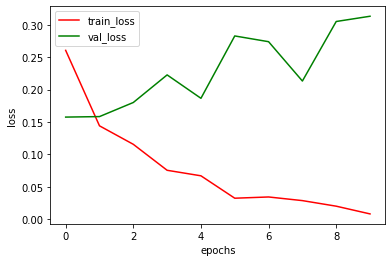

In [42]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
length = len(val_loss)
plt = sns.lineplot(y= train_loss, x = np.arange(length), label = 'train_loss', color = 'r')
sns.lineplot(y= val_loss, x = np.arange(length), label = 'val_loss', color = 'g')
plt.set_xlabel('epochs')
plt.set_ylabel('loss')

In [43]:
cnnLSTM_TweetModel = load_model('cnnLSTM_TweetModel.h5')

loss, acc = cnnLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = cnnLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)

1168/1168 [==============================] - 0s 426us/step
dev evaluation: 0.15749187767505646  /  0.9332191780821918
779/779 [==============================] - 0s 118us/step
test evaluation: 0.14555238361383127  /  0.9319640564061558


---

Loss/Acc of the different models


Text(0, 0.5, 'val_acc')

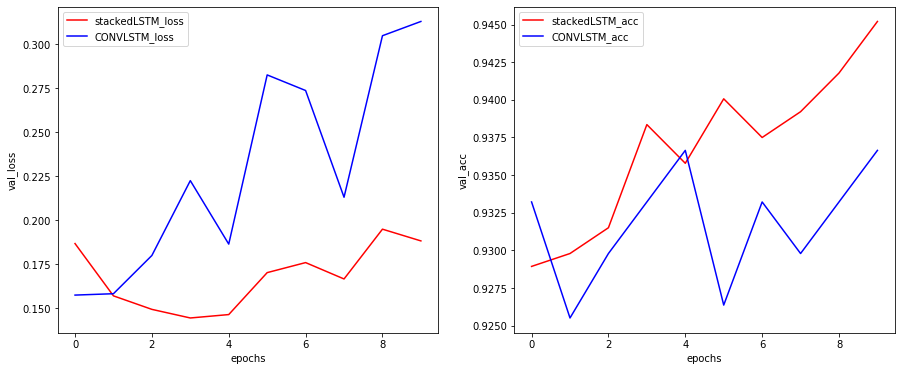

In [45]:
import matplotlib.pyplot as plt
l1 = history1.history['val_loss']
l2 = history2.history['val_loss']


acc1 = history1.history['val_acc']
acc2 = history2.history['val_acc']


fig, ax = plt.subplots(1, 2, figsize = (6,6))
fig.set_size_inches(15,6)

print('Loss/Acc of the different models')

sns.lineplot(y= l1, x = np.arange(len(l1)), label = 'stackedLSTM_loss', color = 'r', ax= ax[0])
sns.lineplot(y= l2, x = np.arange(len(l2)), label = 'CONVLSTM_loss', color = 'b',  ax= ax[0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('val_loss')

sns.lineplot(y= acc1, x = np.arange(len(acc1)), label = 'stackedLSTM_acc', color = 'r', ax= ax[1])
sns.lineplot(y= acc2, x = np.arange(len(acc2)), label = 'CONVLSTM_acc', color = 'b',  ax= ax[1])

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('val_acc')

####  Ensembling
<a id="c36"></a>

In [49]:
#Ensembling

ypred1 = stackedLSTM_TweetModel.predict(test_tweets)
ypred2 = cnnLSTM_TweetModel.predict(test_tweets)

ypred = (ypred1 + ypred2) / 2


Label = []
for ys in ypred2:
  if ys > .5:
    Label.append("Sports")
  else:
    Label.append("Politics")
  
Label= pd.DataFrame(Label, columns=["Label"])
sub = pd.concat([test.TweetId, Label], axis = 1)
print(sub)

!rm sub.csv
sub.to_csv("sub.csv", index=False)
!kaggle competitions submit -c deeptweets -f sub.csv -m ""

                 TweetId     Label
0     306486520121012224    Sports
1     286353402605228032    Sports
2     289531046037438464  Politics
3     306451661403062273  Politics
4     297941800658812928    Sports
...                  ...       ...
2605  282023761044189184    Sports
2606  303879735006601216  Politics
2607  297956846046703616    Sports
2608  304265049537658880  Politics
2609  306430391928115200  Politics

[2610 rows x 2 columns]
100% 67.6k/67.6k [00:05<00:00, 12.3kB/s]
Successfully submitted to DeepTweets

Summary:



<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Dev_loss</th>
    <th>Test_loss</th>
    <th>Kaggle_accuracy</th>
  </tr>
  <tr>
    <td>Simple model</td>
    <td>0.1851</td>
    <td>0.2839</td>
    <td>----------</td>
  </tr>
  <tr>
    <td>Tuned Simple model</td>
    <td>----------</td>
    <td>0.1856</td>
    <td>0.8863</td>
  </tr>
  <tr>
    <td>Stacked LSTM model</td>
    <td>0.1395</td>
    <td>0.1636</td>
    <td>0.8902</td>
  </tr>
  <tr>  
    <td>CNN-LSTM model</td>
    <td>0.1575</td>
    <td>0.1455</td>
    <td>0.8838</td>
    
  </tr>
  
  <tr>  
    <td>Ensembling</td>
    <td>----------</td>
    <td>----------</td>
    <td>0.8863</td>
  </tr>  
</table>




#### Data augmentation
<a id="c37"></a>

Data augmentation is great way to unsure generalization and avoid overfitting.


We'll use the following:


*   Using synonyms/antonyms
*   Cosine similarity
*   Most common words



In [0]:
train_aug = train.loc[list(X_train.index)]

ind_sports = train_aug[train_aug.Label == 'Sports'].index.tolist()
ind_politics = train_aug[train_aug.Label == 'Politics'].index.tolist()


def get_inds(ind_sports, ind_politics):
  """ Returns random subset of indices"""
  ind_sports = random.sample(ind_sports, int(len(ind_sports)/5))
  ind_politics = random.sample(ind_politics, int(len(ind_politics)/5))

  inds = []
  inds.extend(ind_sports)
  inds.extend(ind_politics)
  return inds


In [51]:
# Synonym/antonyms dict using wordnet 

sim_dict = dict()

for w in progress_bar(vocab):  
  synonyms = []
  antonyms = []
  for syn in wordnet.synsets(w):
    for l in syn.lemmas():
      synm = l.name()      
      if synm in vocab and synm != w:
        synonyms.append(synm)
      if l.antonyms():
        ant = l.antonyms()[0].name()        
        if ant in vocab :
          antonyms.append(ant)
    synonyms.extend(antonyms)
    if len(synonyms) > 0:
      sim_dict[w] = set(synonyms)



In [52]:
# Generating similar sentences
def gen_similar(tweet, sim_dict, n = 3):
  tokens = getToken(tweet)  
  keys= sim_dict.keys()
  res = []  
  for token in tokens:    
    if token not in keys:
      continue
    sim = list(sim_dict[token])    
    for s in sim:      
      res.append(re.sub(token , s, tweet))
  if len(res) > n:
    sample = random.sample(res, n)
  else:
    sample = res

  return sample

gen_similar("obamacare would pay last year east classes people", sim_dict)

['obamacare would pay lowest year east classes people',
 'obamacare would pay conclusion year east classes people',
 'obamacare would salary last year east classes people']

In [53]:
inds = get_inds(ind_sports, ind_politics)
new_ind = train_aug.index.max() + 1

for i in tqdm(inds):    
  r = train_aug.loc[i, :]
  gen_sim = gen_similar(r.TweetText, sim_dict)  
  for gen in gen_sim:
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = gen, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


100%|██████████| 908/908 [00:05<00:00, 156.01it/s]


In [54]:
# Similar words using the cosine similarity on between the embedding vectors
def cos_sim(u, v):
  num = u.dot(v)
  denom = np.sqrt(np.sum(u ** 2)) * np.sqrt(np.sum(v ** 2))
  return num / denom

cos_sim(w2v['ball'], w2v['player'])

0.591834566192892

In [55]:
def most_sim(word, threshold = .7):
  u = w2v[word]
  for w in vocab:
    if cos_sim(u, w2v[w]) >= threshold:
      return w  
  return word
most_sim('song')  

'music'

In [56]:
#E.g 
# given: i like this song
# append : i like this album
max_token_replace = 2
n_token_replace = 0
inds = get_inds(ind_sports, ind_politics)

for i in progress_bar(inds):
  r = train_aug.loc[i,:]
  tokens = getToken(r.TweetText) 
  tokens = random.sample(tokens, len(tokens)) #shuffling the array
  new_r = ''  
  n_token_replace = 0
  for token in tokens:    
    if token in vocab:   
      replacement = most_sim(token)         
      if replacement != token:
        new_r = re.sub(token, replacement, r.TweetText)        
        n_token_replace += 1
        if n_token_replace == max_token_replace:
          break
  if new_r != r.TweetText  and len(new_r) > 0:                  
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


In [57]:
# Adding new rows without low cosine-similarity with the corresponding label

max_token_rm = 2
token_rm = 0
inds = get_inds(ind_sports, ind_politics)

for i in progress_bar(inds):
  r = train_aug.loc[i,:]
  tokens = getToken(r.TweetText) 
  tokens = random.sample(tokens, len(tokens)) #shuffling the array
  new_r = ''  
  token_rm = 0
  for token in tokens:    
    if token in vocab:            
      if cos_sim(w2v[token], w2v[r.Label.lower()]) < 0:
        new_r = re.sub(token, '', r.TweetText)        
        token_rm += 1
        if token_rm == max_token_rm:
          break
  if new_r != r.TweetText  and len(new_r) > 0:                  
    row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = r.Label), index= [new_ind])
    train_aug = train_aug.append(row , ignore_index=False, sort = False)    
    new_ind += 1


In [58]:
#Adding random sentences using the most common keywords
h_sports = []
h_politics = []
for i, r in tqdm(train.iterrows()):  
  tokens = getToken(r.TweetText)
  for token in tokens:        
    if r.Label == 'Sports':
      h_sports.append(token)
    else:
      h_politics.append(token)

common_sports = Counter(h_sports).most_common(40)
common_politics = Counter(h_politics).most_common(40)
print()
print('Sports # freq ', common_sports)
print('Politics # freq ',common_politics)

def generate_sentence(sport = True):
  i = random.randint(3, MAXLEN-1)
  sentence = ''
  if sport:
    for w, _ in random.sample(common_sports, i):
      sentence += w + ' '
  else:
    for w, _ in random.sample(common_politics, i):
      sentence += w + ' '

  return sentence
  
generate_sentence(sport = False)

6490it [00:03, 1641.87it/s]



Sports # freq  [('score', 575), ('rt', 406), ('indvaus', 347), ('test', 317), ('bcci', 202), ('runs', 196), ('bbl', 196), ('atp', 183), ('bigfinals', 165), ('cfc', 162), ('tennis', 146), ('win', 143), ('final', 142), ('first', 139), ('aus', 135), ('india', 133), ('game', 122), ('day', 119), ('team', 118), ('thanks', 107), ('great', 106), ('australia', 105), ('time', 105), ('one', 104), ('england', 103), ('cricket', 102), ('gbfedcup', 93), ('match', 92), ('back', 90), ('see', 89), ('new', 87), ('good', 85), ('v', 84), ('get', 83), ('today', 83), ('wicket', 82), ('live', 82), ('ausopen', 80), ('watch', 79), ('play', 79)]
Politics # freq  [('president', 346), ('rt', 319), ('obama', 276), ('pm', 267), ('u2019s', 164), ('conference', 159), ('video', 157), ('new', 153), ('nelsonmandela', 148), ('medvedev', 144), ('minister', 142), ('press', 140), ('secretary', 136), ('live', 135), ('chief', 130), ('cabinet', 130), ('meeting', 121), ('prime', 115), ('us', 114), ('nhttp', 113), ('today', 111)

'india day pm english obama medvedev '

In [0]:
for _ in range(200):
  new_r = generate_sentence()
  row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = 'Sports'), index= [new_ind])
  train_aug = train_aug.append(row , ignore_index=False, sort = False)    
  new_ind += 1
  new_r = generate_sentence(sport = False)
  row = pd.DataFrame(dict(TweetId = 'data_aug', TweetText = new_r, Label = 'Politics'), index= [new_ind])
  train_aug = train_aug.append(row , ignore_index=False, sort = False)    
  new_ind += 1
    

,TweetId,Label,TweetText
10231,data_aug,Politics,economic india barackobama video cabinet obama...
10232,data_aug,Sports,great score cricket new bbl tennis bigfinals s...
10233,data_aug,Politics,state first january minister time press vladim...
10234,data_aug,Sports,get one first win back time test score bbl new...
10235,data_aug,Politics,time us america


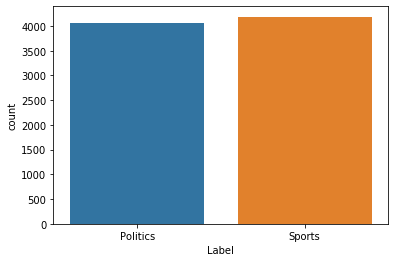

In [60]:
display(train_aug.tail())
sns.countplot(train_aug.Label)

In [61]:
x_train_aug = sentences2indice(np.array(train_aug.TweetText), w2i, vocab, MAXLEN)

lb = LabelEncoder().fit(train.Label)
Y_train_aug = lb.transform(train_aug.Label)

#### Final evaluation
<a id="c38"></a>

In [0]:
# We will also use random fine-tuning
BATCH_SIZE = [32, 64 ,128]
LEARNING_RATE = [0.001, 0.01]
n_a = [32, 64, 128]
n_l = [32, 64]
DROPOUT = [0, 0.2, 0.5]

In [63]:
ckpt = ModelCheckpoint('stackedLSTM_TweetModel_aug.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=0)


best_params1 = dict()
min_loss = 100
for _ in range(10):
  batch_size = random.choice(BATCH_SIZE)
  lr = random.choice(LEARNING_RATE)

  a = random.choice(n_a)
  l = random.choice(n_l)
  d = random.choice(DROPOUT)
  
  stackedLSTM_TweetModel = StackedLSTM_TweetModel(a, l, d, lr, (MAXLEN,))
  hist = stackedLSTM_TweetModel.fit(x_train_aug, Y_train_aug, batch_size= batch_size, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 0, callbacks = [ckpt])
  if min(hist.history['val_loss']) < min_loss:
    best_params1['BATCH_SIZE'] = batch_size
    best_params1['LEARNING_RATE'] = lr
    best_params1['n_a'] = a
    best_params1['n_l'] = l
    best_params1['DROPOUT'] = d

print(best_params1)

{'BATCH_SIZE': 64, 'LEARNING_RATE': 0.01, 'n_a': 64, 'n_l': 32, 'DROPOUT': 0.5}


In [84]:
stackedLSTM_TweetModel = load_model('stackedLSTM_TweetModel_aug.h5')

loss, acc = stackedLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = stackedLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 4s 3ms/step
dev evaluation: 0.14085765101321757  /  0.9452054794520548
779/779 [==============================] - 0s 168us/step
test evaluation: 0.1414194626779091  /  0.9460847243877063


In [65]:
ckpt = ModelCheckpoint('CNNLSTM_TweetModel_aug.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=0)


best_params2 = dict()
min_loss = 100
for i in range(10):
  
  batch_size = random.choice(BATCH_SIZE)
  lr = random.choice(LEARNING_RATE)

  a = random.choice(n_a)
  l = random.choice(n_l)
  d = random.choice(DROPOUT)
  

  cnnLSTM_TweetModel = CNNLSTM_TweetModel(a, l, d, lr, (MAXLEN,))  
  hist = cnnLSTM_TweetModel.fit(x_train_aug, Y_train_aug, batch_size= batch_size, epochs = 10, validation_data= (x_dev, Y_dev), verbose = 0, callbacks = [ckpt])
  
  if min(hist.history['val_loss']) < min_loss:
    best_params2['BATCH_SIZE'] = batch_size
    best_params2['LEARNING_RATE'] = lr
    best_params2['n_a'] = a
    best_params2['n_l'] = l
    best_params2['DROPOUT'] = d


print(best_params2)  

{'BATCH_SIZE': 32, 'LEARNING_RATE': 0.001, 'n_a': 32, 'n_l': 32, 'DROPOUT': 0.2}


In [83]:
cnnLSTM_TweetModel = load_model('CNNLSTM_TweetModel_aug.h5')

loss, acc = cnnLSTM_TweetModel.evaluate(x_dev, Y_dev)
print('dev evaluation:' , loss, ' / ',acc)
loss, acc = cnnLSTM_TweetModel.evaluate(x_test, Y_test)
print('test evaluation:' , loss, ' / ',acc)


1168/1168 [==============================] - 4s 3ms/step
dev evaluation: 0.14507235188598502  /  0.9323630136986302
779/779 [==============================] - 0s 136us/step
test evaluation: 0.12389588616166708  /  0.9460847243877063


,TweetText,Label,predLabel
6129,@madmanweb that's what I laughed !,Politics,Sports
21,"'Sadly, Sharmila Tagore could not come as she was ailing...'",Sports,Politics
3055,'@SAMI_hadyh thanks.',Politics,Sports
1044,'@aGaInStcOmMuNaL thank you :)',Politics,Sports
1165,"'Thanks for the suggestions. I may not have answers, but will ensure that those who do hear you. The rape survivor &amp; constable deserve better'",Politics,Sports
...,...,...,...
3984,"'@thebf_ Ok, thanks for letting us know. We tried to be more up to date with different views of the Open. Glad that came across :-) Thanks.'",Sports,Politics
1048,'RT @imsabbah: @BDUTT @sagarikaghose FYI. Please tag with #MisogynyAlert for any instances of online misogyny. We are planning interventi ...',Politics,Sports
1897,'@DriveDontDie yeps. Seen both seasons',Politics,Sports
5125,'Job opportunities at Prasar Bharati-visit http://t.co/xMEf2apI',Politics,Sports


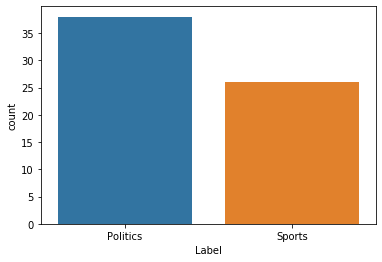

In [85]:
# Evaluation over the dev set
ypred1 = stackedLSTM_TweetModel.predict(x_dev)
ypred2 = cnnLSTM_TweetModel.predict(x_dev)


ypred = (ypred1 + ypred2) / 2

label = []

for y in ypred:
  if y > .5:
    label.append("Sports")
  else:
    label.append("Politics") 

label= pd.DataFrame(label, index = X_dev.index, columns=["predLabel"])
y_dev = pd.Series(lb.inverse_transform(Y_dev.astype(int)), name = 'Label', index = X_dev.index)
res = pd.concat([X_dev,  y_dev, label], axis=1)
res = res.loc[res.predLabel != res.Label]
pd.set_option('display.max_colwidth', -1)

display(res)
sns.countplot(res.Label)


This is great the models performs now better on politics (recall the error analysis previously)

Now let's compare the performance of our model to human(myself) performance

In [0]:
# Ensembling over the test data
ypred1 = stackedLSTM_TweetModel.predict(x_test)
ypred2 = cnnLSTM_TweetModel.predict(x_test)

ypred = (ypred1 + ypred2) / 2

label = []

for y in ypred:
  if y > .5:
    label.append(1)
  else:
    label.append(0) 


In [74]:
human_test = pd.read_excel('humanLabeledX_test1.xlsx', index_col=0, header= None)
print('models f1 score: ',f1_score(Y_test[:100], label[:100]))
print('Human f1 score: ',f1_score(Y_test[:100], human_test[1]))

models f1 score:  0.9444444444444444
Human f1 score:  0.8679245283018869


This is proof that we are near the optimal/bayesian error, with that we are ready to submit the results

---


In [0]:
lb.classes_

array(['Politics', 'Sports'], dtype=object)

In [0]:
# More training over dev/test data
stackedLSTM_TweetModel.fit(x_dev, Y_dev, batch_size= best_params1['BATCH_SIZE'], epochs = 3, verbose = 0 )
stackedLSTM_TweetModel.fit(x_test, Y_test, batch_size= best_params1['BATCH_SIZE'], epochs = 3, verbose = 0 )

cnnLSTM_TweetModel.fit(x_dev, Y_dev, batch_size= best_params2['BATCH_SIZE'], epochs = 3, verbose = 0 )
cnnLSTM_TweetModel.fit(x_test, Y_test, batch_size= best_params2['BATCH_SIZE'], epochs = 3, verbose = 0 )

In [82]:
# #Kaggle submission

ypred1 = stackedLSTM_TweetModel.predict(test_tweets)
ypred2 = cnnLSTM_TweetModel.predict(test_tweets)

ypred = (ypred1 + ypred2) / 2



Label = []
for ys in ypred:
  if ys > .5:    
    Label.append("Sports")
  else:
    Label.append("Politics")
  
Label= pd.Series(Label, name = "Label")
sub = pd.concat([test.TweetId, Label], axis = 1)
print(sub)
!rm sub.csv
sub.to_csv("sub.csv", index=False)
!kaggle competitions submit -c deeptweets -f sub.csv -m ""

                 TweetId     Label
0     306486520121012224  Sports  
1     286353402605228032  Sports  
2     289531046037438464  Politics
3     306451661403062273  Politics
4     297941800658812928  Sports  
...                  ...     ...  
2605  282023761044189184  Sports  
2606  303879735006601216  Politics
2607  297956846046703616  Sports  
2608  304265049537658880  Politics
2609  306430391928115200  Politics

[2610 rows x 2 columns]
100% 67.4k/67.4k [00:03<00:00, 18.8kB/s]
Successfully submitted to DeepTweets

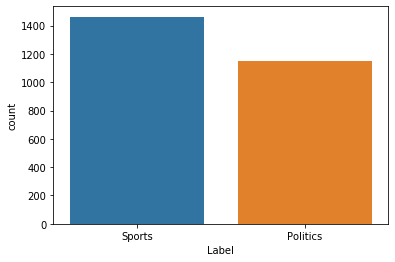

In [0]:
sns.countplot(sub.Label)

Results after augmentation of x_train:



<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Dev_loss</th>
    <th>Test_loss</th>
    <th>Kaggle_accuracy</th>
  </tr>    
  <tr>  
    <td>Stacked LSTM model</td>
    <td>0.1409</td>
    <td>0.1414</td>    
    <td></td>
  </tr>
  <tr>    
    <td>CNN-LSTM model</td>
    <td>0.1450</td>
    <td>0.1239</td>
    <td></td>
    
  </tr>  
  <tr>  
    <td>Ensembling</td>
    <td>----------</td>
    <td>----------</td>
    <td>0.9144</td>
  </tr>
</table>




## 4 - Conclusion
<a id="c4"></a>

Conclusion and perspectives:


The results seems satisfying, but we could have explore more options:

*   Start with simpler machine learning approche: Naive bayes
*   Other preprocessing techniques (Lemmatization / Stemming / use of tf-idf)
*   Remove other non telling sentences from X_train (e.g '@rainaa102 Thank you')
*   More hyperparams fine-tuning 
*   Try GRUs, deeper CNN-LSTM blocks
*   Transfert learning
*   Concatenatening different embedding + lstm (https://www.kaggle.com/shujian/blend-of-lstm-and-cnn-with-4-embeddings-1200d)
*   Dynamic word embedding BERT (https://medium.com/@adriensieg/from-pre-trained-word-embeddings-to-pre-trained-language-models-focus-on-bert-343815627598)

